1. Install dependencies

In [ ]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.5 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.2
    Uninstalling transformers-4.55.2:
      Successfully uninstalled transformers-4.55.2


In [ ]:
!pip install datasets scikit-learn matplotlib seaborn

2. Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

3. Load datasets

In [ ]:
def load_datasets():
    d1 = pd.read_csv("/content/drive/MyDrive/Системи за поддршка при одлучувањето/CyberBullying Comments Dataset.csv")
    d1 = d1.rename(columns={"Text": "text", "CB_Label": "label"})

    d2 = pd.read_csv("/content/drive/MyDrive/Системи за поддршка при одлучувањето/cb_multi_labeled_balanced.csv")

    d2["label"] = d2["label"].apply(lambda x: 0 if x == "not_cyberbullying" else 1)

    d3 = pd.read_csv("/content/drive/MyDrive/Системи за поддршка при одлучувањето/cyberbullying_tweets.csv")
    d3 = d3.rename(columns={"tweet_text": "text", "cyberbullying_type": "label"})
    d3["label"] = d3["label"].apply(lambda x: 0 if x == "not_cyberbullying" else 1)

    d4 = pd.read_csv("/content/drive/MyDrive/Системи за поддршка при одлучувањето/HateSpeechDatasetBalanced.csv")
    d4 = d4.rename(columns={"Content": "text", "Label": "label"})

    return d1, d2, d3, d4

4. Merge datasets & balance

In [ ]:
def prepare_binary_dataset(d1, d2, d3, d4, sample_size=None):
    df = pd.concat([d1, d2, d3, d4], ignore_index=True)

    min_count = df["label"].value_counts().min()
    df_balanced = (
        df.groupby("label", group_keys=False)
        .apply(lambda x: x.sample(min_count, random_state=42))
        .sample(frac=1, random_state=42)
    )

    if sample_size:
        df_balanced = df_balanced.sample(sample_size, random_state=42)

    return df_balanced

5. Custom Dataset Class

In [ ]:
class CyberbullyingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

6. Dataset splitting on train, validation and test datasets

In [ ]:
def split_train_val_test(df, test_size=0.15, val_size=0.15, random_state=42):
    test_val_size = test_size+val_size
    train_df, test_val_df = train_test_split(df, test_size=test_val_size, random_state=random_state, stratify=df["label"])

    test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=random_state, stratify=test_val_df["label"])

    return train_df, val_df, test_df

7. Tokenize function

In [ ]:
def tokenize_split(df_train, df_val, df_test, tokenizer, max_length=128):
    train_encodings = tokenizer(df_train["text"].tolist(), truncation=True, padding=True, max_length=max_length)
    val_encodings   = tokenizer(df_val["text"].tolist(), truncation=True, padding=True, max_length=max_length)
    test_encodings  = tokenizer(df_test["text"].tolist(), truncation=True, padding=True, max_length=max_length)

    train_dataset = CyberbullyingDataset(train_encodings, df_train["label"].tolist())
    val_dataset   = CyberbullyingDataset(val_encodings, df_val["label"].tolist())
    test_dataset  = CyberbullyingDataset(test_encodings, df_test["label"].tolist())

    return train_dataset, val_dataset, test_dataset

8. Metrics

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision_class0": precision[0],
        "recall_class0": recall[0],
        "f1_class0": f1[0],
        "precision_class1": precision[1],
        "recall_class1": recall[1],
        "f1_class1": f1[1],
    }

9. Train model

In [ ]:
def train_model(model_name, train_dataset, val_dataset, num_labels=2, epochs=3):
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

    training_args = TrainingArguments(
        output_dir=f"./results_{model_name}",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir=f"./logs_{model_name}",
        load_best_model_at_end=True,
        report_to="tensorboard"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer

10. Confusion Matrix

In [ ]:
def plot_confusion_matrix(trainer, val_dataset, class_names=["Not Cyberbullying", "Cyberbullying"]):
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

11. Test dataset evaluation

In [ ]:
def evaluate_test_set(trainer, test_dataset, class_names=["Not Cyberbullying", "Cyberbullying"]):
    preds = trainer.predict(test_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    print(f"Test Accuracy: {acc:.4f}")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

12. Main script

/tmp/ipython-input-1094898147.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


label
1    25036
0    24964
Name: count, dtype: int64
Train/Val/Test sizes: 35000 7500 7500


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Class0,Recall Class0,F1 Class0,Precision Class1,Recall Class1,F1 Class1
1,0.359100,0.338121,0.849467,0.809366,0.913752,0.858397,0.901284,0.785353,0.839334
2,0.244400,0.313685,0.870800,0.862591,0.881709,0.872045,0.879357,0.859920,0.869530
3,0.151300,0.387744,0.866933,0.841073,0.904406,0.871590,0.896919,0.829561,0.861926


BERT Test Set Results:


Test Accuracy: 0.8665
Not Cyberbullying: Precision=0.8652, Recall=0.8678, F1=0.8665
Cyberbullying: Precision=0.8678, Recall=0.8653, F1=0.8666


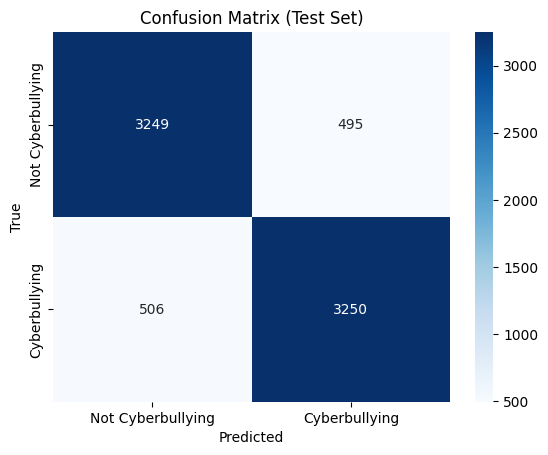

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Class0,Recall Class0,F1 Class0,Precision Class1,Recall Class1,F1 Class1
1,0.371000,0.329087,0.858400,0.846730,0.874766,0.860520,0.870834,0.842077,0.856214
2,0.265300,0.309585,0.871733,0.856521,0.892657,0.874215,0.888240,0.850866,0.869151
3,0.191900,0.359507,0.866533,0.837101,0.909746,0.871913,0.901458,0.823435,0.860682


RoBERTa Test Set Results:


Test Accuracy: 0.8713
Not Cyberbullying: Precision=0.8658, Recall=0.8785, F1=0.8721
Cyberbullying: Precision=0.8771, Recall=0.8642, F1=0.8706


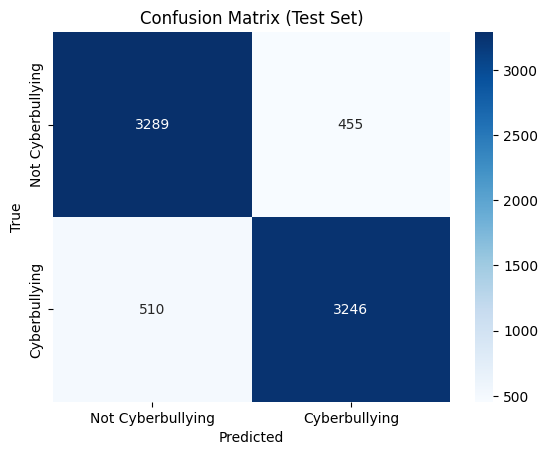

In [ ]:
if __name__ == "__main__":
    d1, d2, d3, d4 = load_datasets()
    df = prepare_binary_dataset(d1, d2, d3, d4, sample_size=50000)
    print(df["label"].value_counts())

    train_df, val_df, test_df = split_train_val_test(df)
    print("Train/Val/Test sizes:", len(train_df), len(val_df), len(test_df))

    # Train BERT
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    train_dataset, val_dataset, test_dataset = tokenize_split(train_df, val_df, test_df, tokenizer)
    bert_trainer = train_model("bert-base-uncased", train_dataset, val_dataset, epochs=3)

    print("BERT Test Set Results:")
    evaluate_test_set(bert_trainer, test_dataset)

    # Train RoBERTa
    tokenizer = AutoTokenizer.from_pretrained("roberta-base")
    train_dataset, val_dataset, test_dataset = tokenize_split(train_df, val_df, test_df, tokenizer)
    roberta_trainer = train_model("roberta-base", train_dataset, val_dataset, epochs=3)

    print("RoBERTa Test Set Results:")
    evaluate_test_set(roberta_trainer, test_dataset)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(trainer, model_name="Model"):
    history = trainer.state.log_history

    train_loss = [log["loss"] for log in history if "loss" in log]
    val_loss   = [log["eval_loss"] for log in history if "eval_loss" in log]

    epochs = range(1, len(val_loss) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_loss)+1), train_loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
    plt.xlabel("Steps / Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss Curves for {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

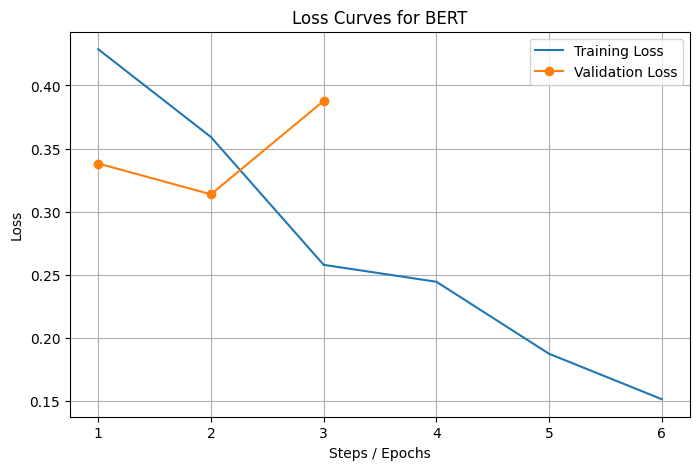

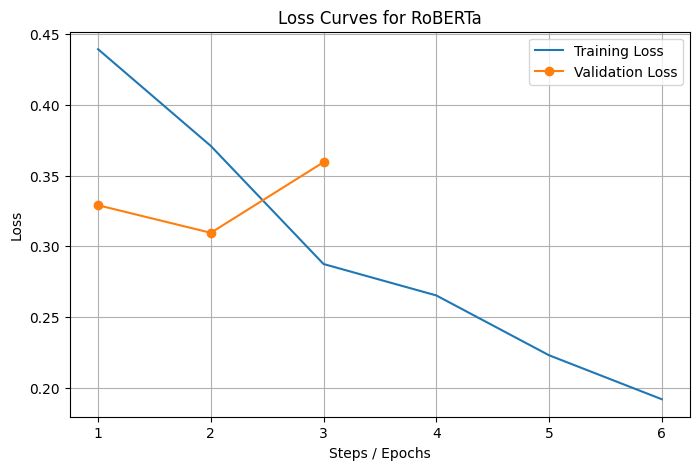

In [ ]:
plot_loss_curves(bert_trainer, "BERT")
plot_loss_curves(roberta_trainer, "RoBERTa")